# PREVISIONE DEI NUOVI POSITIVI AL COVID-19
**Progetto per l'esame di Programmazione di applicazioni di Data Intensive**

Realizzato da: **Viola Leonardo**  
`leonardo.viola2@studio.unibo.it`

## Setup
Importare i package necessari per verificarne l'installazione.

In [1]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

# DESCRIZIONE PROBLEMA

Il dataset che è possibile reperire a questo [link](https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-andamento-nazionale.json), contiene i dati relativi alla diffusione del covid-19 in Italia a partire da inizio 2020. L'obiettivo è quello di predire l'andamento dei nuovi positivi.  

In [2]:
URL = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json"
import os.path
if not os.path.exists("covid.json"):
    from urllib.request import urlretrieve
    urlretrieve(URL, "covid.json")

file_path = os.path.abspath("covid.json")


# ESPLORAZIONE DEI DATI

In [3]:
dataset = pd.read_json(file_path)
dataset

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,...,4324,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,...,8623,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,...,9587,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,...,12014,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,...,15695,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636,2024-08-17T17:00:00,ITA,2210,66,2276,196002,198278,1548,2271,26430452,...,282863640,70368338.0,None,5.0,NaN,NaN,9947477.0,16878321.0,103122416.0,179741224.0
1637,2024-08-18T17:00:00,ITA,2169,75,2244,196751,198995,717,1426,26431157,...,282872244,70369770.0,None,12.0,NaN,NaN,9947653.0,16879571.0,103123303.0,179748941.0
1638,2024-08-19T17:00:00,ITA,2224,79,2303,196819,199122,127,956,26431971,...,282878256,70370959.0,None,7.0,NaN,NaN,9947856.0,16880324.0,103123879.0,179754377.0
1639,2024-08-20T17:00:00,ITA,2239,78,2317,198198,200515,1393,3339,26433903,...,282896563,70373411.0,None,10.0,NaN,NaN,9948380.0,16883139.0,103125585.0,179770978.0


Le features disponibili sono 24 e sono:

1. `data`: Data dell'informazione
2. `stato`: Stato di riferimento     
3. `ricoverati_con_sintomi`: il numero di ricoverati con sintomi
4. `terapia_intensiva`: il numero di ricoverati in terapia intensiva
5. `totale_ospedalizzati`: Totale ospedalizzati
6. `isolamento_domiciliare`: Persone in isolamento domiciliare
7. `totale_positivi`: Totale attualmente positivi (ospedalizzati + isolamento domiciliare)
8. `variazione_totale_positivi`: Variazione del totale positivi (totale_positivi giorno corrente - totale_positivi giorno precedente)
9. `nuovi_positivi`: Nuovi attualmente positivi (totale_casi giorno corrente - totale_casi giorno precedente)
10. `dimessi_guariti`: Persone dimesse guarite
11. `deceduti`: Persone decedute
12. `casi_da_sospetto_diagnostico`: Casi positivi al tampone emersi da attività clinica (NON PIÙ POPOLATO)
13. `casi_da_screening`: Casi positivi emersi da indagini e test (NON PIÙ POPOLATO)
14. `totale_casi`: Totale casi positivi
15. `tamponi`: Totale tamponi (processati con test molecolari)
16. `casi_testati`: Totale dei soggetti sottoposti al test
17. `note`: Note
18. `ingressi_terapia_intensiva`: Ingressi giornalieri in terapia intensiva
19. `note_test`: Note sui test effettuati
20. `note_casi`: Note sui casi testati
21. `totale_positivi_test_molecolare`: Numero di positivi ai test molecolari
22. `totale_positivi_test_antigenico_rapido`: Numero di positivi ai test antigenici
23. `tamponi_test_molecolare`: Numero di tamponi con test_molecolare
24. `tamponi_test_antigenico_rapido`: Numero tamponi con test antigenico rapido

Dato un determinato giorno, l'obiettivo è predire il numero di nuovi positivi in quella data, quindi la variabile target è `nuovi_positivi`.
Si tratta per lo più di variabili continue, l'unica variabile categorica è `stato` che possiamo eliminare, perché trattandosi di un dataset contenente i dati del covid in Italia, è ovvio che ogni riga si riferisce all'Italia.
Oltre a `stato` sono presenti altre features che possono essere eliminate perché non utili al nostro scopo.

# Pulizia dei dati

Come prima cosa, semplifico il formato della data, eliminando l'ora, e poi la imposto come indice del dataframe:

In [4]:
from datetime import datetime

# Funzione per convertire la data nel formato desiderato
def converti_data(data_str):
    return datetime.fromisoformat(data_str).date().isoformat()

# Applica la funzione di conversione alla serie
dataset["data"] = dataset["data"].apply(converti_data)

dataset.set_index("data", inplace=True)


Dato che il nostro dataset è formato da molte colonne possiamo passare all'eliminazione di tutti quei dati che sicuramente non ci serviranno, ovvero: `stato`, `note`, `note_test` e `note_casi`

In [5]:
dataset = dataset.drop(['stato', 'note', 'note_test', 'note_casi'], axis=1)

Altri dati che sicuramente non sono utili a predire il numero di nuovi positivi sono: il numero dei deceduti, i dimessi guariti, gli ospedalizzati, il numero di persone in terapia intensiva, il numero di ingressi in terapia intensiva, i ricoverati con sintomi e le persone in isolamento domiciliare.


In [6]:
dataset = dataset.drop(['deceduti', 'isolamento_domiciliare', 'dimessi_guariti', 'totale_ospedalizzati', 'terapia_intensiva', 'ingressi_terapia_intensiva', 'ricoverati_con_sintomi'], axis=1)

Inoltre elimino anche le features `casi_da_sospetto_diagnostico` e `casi_da_screening` perché sono poco popolati (infatti nella descrizione del dataset era specificato che queste features non venivano più popolate) e quindi sono inutili ai fini dell'addestramento del modello.
Infatti:

In [7]:
valoriNaN = dataset["casi_da_sospetto_diagnostico"].isna().sum()
print(f"{valoriNaN} righe di 'casi_da_sospetto_diagnostico' con valore Nan su {len(dataset['casi_da_sospetto_diagnostico'])} righe")

1479 righe di 'casi_da_sospetto_diagnostico' con valore Nan su 1641 righe


In [ ]:
valoriNaN = dataset["casi_da_screening"].isna().sum()
print(f"{valoriNaN} righe di 'casi_da_screening' con valore Nan su {len(dataset['casi_da_screening'])} righe")

1479 righe di 'casi_da_screening' con valore Nan su 1641 righe


Procedo all'eliminazione:

In [8]:
dataset = dataset.drop(['casi_da_sospetto_diagnostico', 'casi_da_screening'], axis=1)

# Selezione delle features rilevanti

Dato che noi vogliamo predire l'andamento dei nuovi positivi è logico pensare che questo dato sia strettamente correlato al numero di tamponi effettuato, infatti mi aspetto che più tamponi vengono effettuati e più il numero di nuovi positivi sarà maggiore.

Dato che la feature `tamponi` del dataframe non indica il numero di tamponi effettuati in una certa data, ma il totale dei tamponi effettuati fino a quella data, creo una nuova feature `nuovi_tamponi`, creata sottraendo al numero di tamponi della data corrente i tamponi della giornata precedente.  

In [9]:
dataset["nuovi_tamponi"] = dataset["tamponi"] - dataset["tamponi"].shift(1)
dataset["nuovi_tamponi"].iloc[0] = dataset["tamponi"].iloc[0]
#dataset["nuovi_tamponi"]

Dopo aver calcolato questa nuova feature controllo i suoi valori, mi aspetto che siano tutti valori positivi:

In [10]:
(dataset["nuovi_tamponi"]<0).sum()

1

Invece è presente un valore negativo, precisamente quello con indice *'2020-12-17'*.

Seleziono questo record insieme al successivo e al precedente:

In [11]:
dataset.loc[["2020-12-16","2020-12-17","2020-12-18"]]

,totale_positivi,variazione_totale_positivi,nuovi_positivi,totale_casi,tamponi,casi_testati,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,nuovi_tamponi
data,,,,,,,,,,,
2020-12-16,645706,-17607,17572,1888144,24683230,14165961.0,NaN,NaN,NaN,NaN,199489.0
2020-12-17,635343,-10363,18236,1906377,24635720,14246739.0,NaN,NaN,NaN,NaN,-47510.0
2020-12-18,627798,-7545,17992,1921778,24815520,14150088.0,NaN,NaN,NaN,NaN,179800.0


Osserviamo che fino al *2020-12-16* il numero di tamponi totali era *24.683.230* e invece al *2020-12-17* i tamponi totali effettuati erano *24.635.720*, ovvero *47510* in meno, il chè è impossibile.

Suppongo ci sia stato un errore nell'inserimento dei dati, anche perché in data *2020-12-18* il totale era *24.815.520*, quindi assumiamo che in data  *2020-12-17* invece di inserire *24.735.720* (valore che potrebbe essere corretto perché è sia maggiore del giorno precedente che minore del giorno successivo) hanno inserito *24.635.720*, quindi in base a questa assunzione il corretto valore della feature `nuovi_tamponi` è *24.735.720* - *24.683.230* = *52.490*

Quindi assegnamo questo valore alla feature `nuovi_tamponi` nel record con indice *2020-12-17*:

In [12]:
dataset.loc['2020-12-17', 'nuovi_tamponi'] = 52490

Infatti ora non ho più valori negativi:

In [13]:
(dataset["nuovi_tamponi"]<0).sum()

0

<AxesSubplot:xlabel='nuovi_tamponi', ylabel='nuovi_positivi'>

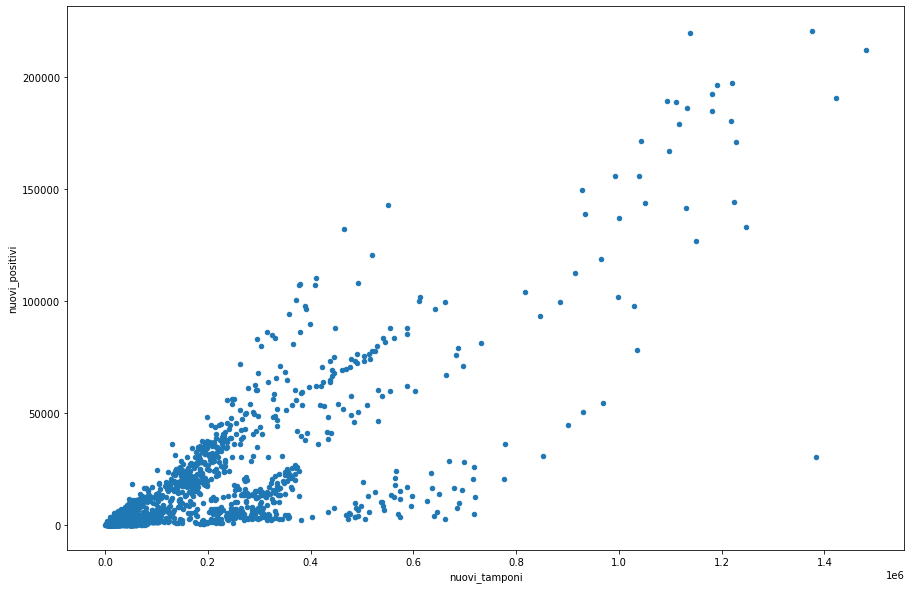

In [14]:
dataset.plot.scatter("nuovi_tamponi", "nuovi_positivi", figsize = (15,10))

Come mi aspettavo il grafico mostra che più il numero di tamponi effettuati è alto e più il numero di nuovi positivi è alto.

Bisogna tenere conto anche di un'altra cosa, per ricevere il risultato di un tampone antigenico rapido bastano 10-15 minuti, mentre per un tampone molecolare ci vogliono 2-3 giorni, quindi il numero di tamponi che effettuo oggi (soprattutto il numero di tamponi molecolari) andrà ad influenzare anche il numero di nuovi positivi dei giorni successivi.

Quindi mi aspetto che il numero di positivi sia influenzato diversamente dal numero di tamponi rapidi e molecolari, per questo, in modo simile a come ho creato la feature `nuovi_tamponi`, creo due nuove features, `nuovi_tamponi_rapidi` e `nuovi_tamponi_molecolari` che equivalgono rispettivamente al numero dei tamponi rapidi e al numero dei tamponi molecolari effettuati in una determinata data.

In [15]:
dataset["nuovi_tamponi_rapidi"] = dataset["tamponi_test_antigenico_rapido"] - dataset["tamponi_test_antigenico_rapido"].shift(1)
dataset["nuovi_tamponi_rapidi"].iloc[0] = dataset["tamponi_test_antigenico_rapido"].iloc[0]
#dataset["nuovi_tamponi_rapidi"]

In [16]:
dataset["nuovi_tamponi_molecolari"] = dataset["tamponi_test_molecolare"] - dataset["tamponi_test_molecolare"].shift(1)
dataset["nuovi_tamponi_molecolari"].iloc[0] = dataset["tamponi_test_molecolare"].iloc[0]
#dataset["nuovi_tamponi_molecolari"]

Ora prima di procedere, verifichiamo per ogni record (tenendo conto che alcuni records contengono valori Nan ancora), che la somma di queste due features equivale al totale (ricordando che il dataframe ha 1641 righe):

In [17]:
records_corretti = (dataset["nuovi_tamponi"] == (dataset["nuovi_tamponi_rapidi"] + dataset["nuovi_tamponi_molecolari"])).sum()
records_nan = dataset["nuovi_tamponi_rapidi"].isna().sum()
totale = records_corretti + records_nan
print(f"Sono presenti {records_corretti} records corretti e {records_nan} con valori Nan, la somma è {totale}")

Sono presenti 1314 records corretti e 327 con valori Nan, la somma è 1641


Ora che abbiamo creato queste nuove features che saranno utili ad addestrare il modello, possiamo eliminare quelle features che non ci servono più, ovvero: `tamponi`, `totale_positivi_test_molecolare`, `totale_positivi_test_antigenico_rapido	`, `tamponi_test_molecolare`, `tamponi_test_antigenico_rapido`

In [18]:
dataset = dataset.drop(['tamponi', 'totale_positivi_test_molecolare', 'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare', 'tamponi_test_antigenico_rapido'], axis=1)
dataset

,totale_positivi,variazione_totale_positivi,nuovi_positivi,totale_casi,casi_testati,nuovi_tamponi,nuovi_tamponi_rapidi,nuovi_tamponi_molecolari
data,,,,,,,,
2020-02-24,221,0,221,229,NaN,4324.0,NaN,NaN
2020-02-25,311,90,93,322,NaN,4299.0,NaN,NaN
2020-02-26,385,74,78,400,NaN,964.0,NaN,NaN
2020-02-27,588,203,250,650,NaN,2427.0,NaN,NaN
2020-02-28,821,233,238,888,NaN,3681.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-08-17,198278,1548,2271,26825798,70368338.0,11072.0,9953.0,1119.0
2024-08-18,198995,717,1426,26827224,70369770.0,8604.0,7717.0,887.0
2024-08-19,199122,127,956,26828180,70370959.0,6012.0,5436.0,576.0


Osservando il dataframe notiamo che ci sono ancora delle features che non sono utili a predire la variabile target, e quindi procedo ad eliminarle, per questo elimino `totale_positivi	`, `variazione_totale_positivi`, `totale_casi` e `casi_testati`

In [19]:
dataset = dataset.drop(['totale_positivi', 'variazione_totale_positivi', 'totale_casi', 'casi_testati'], axis=1)
dataset

,nuovi_positivi,nuovi_tamponi,nuovi_tamponi_rapidi,nuovi_tamponi_molecolari
data,,,,
2020-02-24,221,4324.0,NaN,NaN
2020-02-25,93,4299.0,NaN,NaN
2020-02-26,78,964.0,NaN,NaN
2020-02-27,250,2427.0,NaN,NaN
2020-02-28,238,3681.0,NaN,NaN
...,...,...,...,...
2024-08-17,2271,11072.0,9953.0,1119.0
2024-08-18,1426,8604.0,7717.0,887.0
2024-08-19,956,6012.0,5436.0,576.0


Delle 24 features iniziali sono ancora presenti la variabile target `nuovi_positivi` e l'indice `data`, mentre le altre 3 features presenti nel dataframe sono le features create nei passi precedenti e che sono state derivate da altre features che poi sono state eliminate

# Rilevazione valori nulli

Alcuni valori del dataset sono nulli (valore Nan), infatti:

In [20]:
dataset.isna().sum()

nuovi_positivi                0
nuovi_tamponi                 0
nuovi_tamponi_rapidi        327
nuovi_tamponi_molecolari    327
dtype: int64

Notiamo che i valori Nan non sono relativi al totale dei tamponi e dei nuovi positivi, ma al numero dei tamponi rapidi e molecolari giornalieri.

Dato che la somma dei tamponi rapidi e dei tamponi molecolari giornalieri deve essere pari al numero di tamponi effettuati in una certa data, potremmo suddividere a metà il numero dei tamponi effettuati ed assegnare questi valori ai rispettivi valori Nan.

Esempio:

*nuovi_tamponi_rapidi* = nuovi_tamponi / 2

*nuovi_tamponi_molecolari* = nuovi_tamponi / 2

Posso effettuare questa modifica perché i valori Nan sono relativi agli stessi record tra le diverse features, infatti (ricordando che ci sono 327 valori a Nan per ogni feature):

In [21]:
(dataset["nuovi_tamponi_rapidi"].isna() & dataset["nuovi_tamponi_molecolari"].isna()).sum()

327

Procedo all'assegnamento dei dati:

In [22]:
nanValues = dataset["nuovi_tamponi_rapidi"].isna()
dataset["nuovi_tamponi_molecolari"].loc[nanValues] = dataset["nuovi_tamponi"].loc[nanValues] / 2
dataset["nuovi_tamponi_rapidi"].loc[nanValues] = dataset["nuovi_tamponi"].loc[nanValues] / 2

In [24]:
dataset.isna().sum()

nuovi_positivi              0
nuovi_tamponi               0
nuovi_tamponi_rapidi        0
nuovi_tamponi_molecolari    0
dtype: int64

Controlliamo ora la consistenza del dataframe, ovvero se la somma dei tamponi rapidi e molecolari giornalieri equivale al numero di tamponi effettuati per una certa data (Ricordando che il nostro dataset ha 1641 records).

In [25]:
(dataset["nuovi_tamponi"] == (dataset["nuovi_tamponi_rapidi"] + dataset["nuovi_tamponi_molecolari"])).sum()

1641

Notiamo che la somma dei tamponi rapidi e dei tamponi molecolari equivale al numero di nuovi tamponi giornaliero per ogni riga.

# Analisi dei dati

Osserviamo ora alcuni dati sul dataframe:

In [26]:
dataset.describe()

,nuovi_positivi,nuovi_tamponi,nuovi_tamponi_rapidi,nuovi_tamponi_molecolari
count,1641.000000,1.641000e+03,1.641000e+03,1641.000000
mean,16167.581962,1.724611e+05,1.182705e+05,54190.642291
std,28741.107645,2.101798e+05,1.583326e+05,63136.989721
min,30.000000,9.640000e+02,4.820000e+02,422.000000
25%,1215.000000,3.117800e+04,2.286700e+04,4973.000000
50%,4720.000000,9.270600e+04,5.859100e+04,29336.500000
75%,18765.000000,2.386320e+05,1.482530e+05,88092.500000
max,220532.000000,1.481349e+06,1.335109e+06,366164.000000


Per ogni features i valori minimi sono tutti positivi, come è giusto che sia, quindi le features aggiunte sono state calcolate correttamente, inoltre possiamo osservare che la media giornaliera di tamponi rapidi effettuati è di molto superiore a quella dei tamponi molecolari.

Infatti lo si può evincere anche dal seguente grafico:

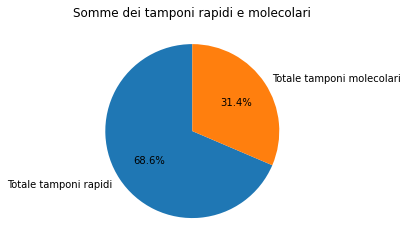

In [27]:
tamponi = dataset[["nuovi_tamponi_rapidi", "nuovi_tamponi_molecolari"]].sum()

plt.pie(tamponi, labels=['Totale tamponi rapidi','Totale tamponi molecolari'], autopct='%1.1f%%', startangle=90)
plt.title('Somme dei tamponi rapidi e molecolari')
plt.show()


Come prevedibile notiamo che il numero dei tamponi rapidi è più alto del numero di tamponi molecolari, ciò è giustificato dai costi ed i tempi di attesa per i tamponi rapidi, che sono inferiori a quelli dei tamponi molecolari.

Osservando invece il grafico dei nuovi positivi e dei tamponi giornalieri, possiamo osservere grande sparsità di dati:

<AxesSubplot:xlabel='nuovi_tamponi', ylabel='nuovi_positivi'>

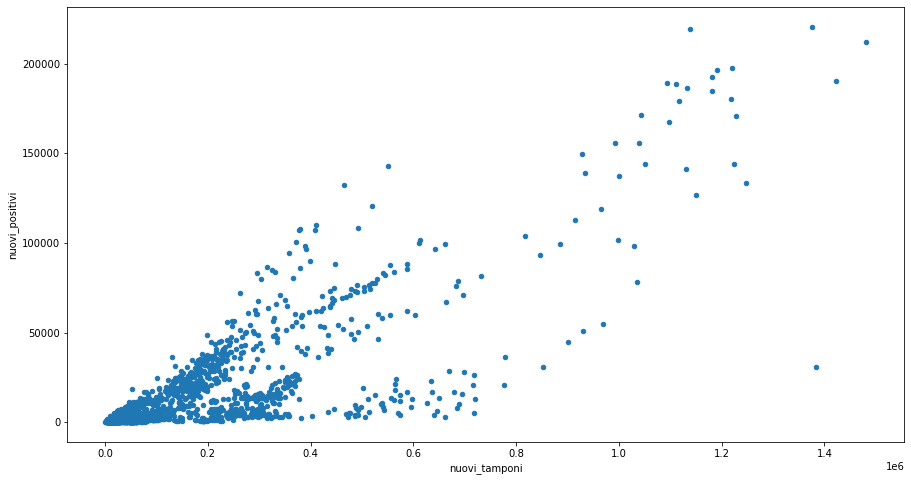

In [28]:
dataset.plot.scatter("nuovi_tamponi", "nuovi_positivi", figsize = (15,8))

La sparsità dei dati è dovuta al diverso andamento dell'epidemia nel tempo, con periodi dove il numero dei positivi era molto alto, e periodi in cui il numero di nuovi positivi era basso, questo dataset raccoglie dati da inizio 2020 fino ad oggi, quindi sono presenti sia i dati relativi ai periodi di 'piena emergenza' sia relativi all'ultimo anno e mezzo in cui l'emergenza è finita.

Proviamo ora a visualizzare dei grafici che ci fanno capire meglio l'andamneto dell'epidemia nel tempo:

In [29]:
indici = pd.to_datetime(dataset.index)

#2020
meta_2020 = pd.to_datetime('2020-08-01')

#2021
inizio_2021 = pd.to_datetime('2021-01-01')
meta_2021 = pd.to_datetime('2021-07-01')

#2022
inizio_2022 = pd.to_datetime('2022-01-01')

primo_quarto_2022 = pd.to_datetime('2022-04-01')
meta_2022 = pd.to_datetime('2022-07-01')
terzo_quarto_2022 = pd.to_datetime('2022-10-01')

#2023
inizio_2023 = pd.to_datetime('2023-01-01')
meta_2023 = pd.to_datetime('2023-07-01')

#2024
inizio_2024 = pd.to_datetime('2024-01-01')

#### CREO I DATASET

dataset1_2020 = dataset[indici < meta_2020]
dataset2_2020 = dataset[(indici > meta_2020 ) & (indici < inizio_2021)]

#2021
dataset1_2021 = dataset[(indici > inizio_2021) & (indici < meta_2021)]
dataset2_2021 = dataset[(indici > meta_2021) & (indici < inizio_2022)]

#2022
dataset1_2022 = dataset[(indici > inizio_2022) & (indici < meta_2022)]
dataset2_2022 = dataset[(indici > meta_2022) & (indici < inizio_2023)]

#2023
dataset_2023 = dataset[(indici > inizio_2023) & (indici < inizio_2024)]
dataset1_2023 = dataset[(indici > inizio_2023) & (indici < meta_2023)]
dataset2_2023 = dataset[(indici > meta_2023) & (indici < inizio_2024)]

#2024
dataset_2024 = dataset[(indici > inizio_2024)]

Una volta creati i dataset in base all'anno, vediamo i risultati graficamente, prima però creiamo una funzione che richiameremo poi per ogni dataset:

In [30]:
def plot_grafico(dataset1, dataset2, label1, label2, title):
    # Creare il grafico
    plt.figure(figsize=(10, 6))
    plt.scatter(dataset1["nuovi_tamponi"], dataset1["nuovi_positivi"], label=label1, color="blue")
    plt.scatter(dataset2['nuovi_tamponi'], dataset2['nuovi_positivi'], label=label2, color="red")

    # Aggiungere etichette e titolo
    plt.xlabel('Tamponi Giornalieri')
    plt.ylabel('Positivi Giornalieri')
    plt.title(title)
    plt.legend()

Mostro i grafici:

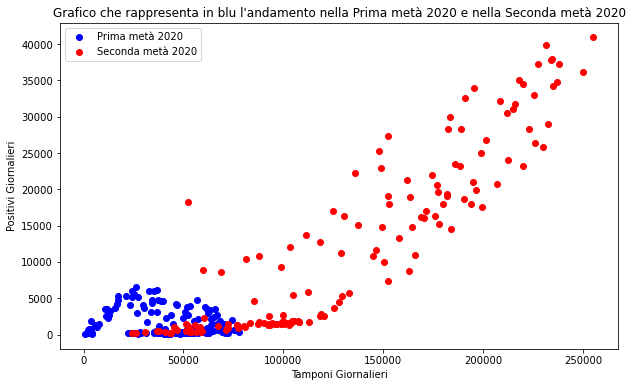

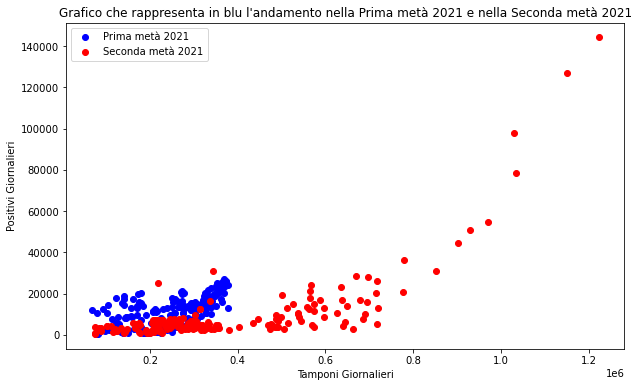

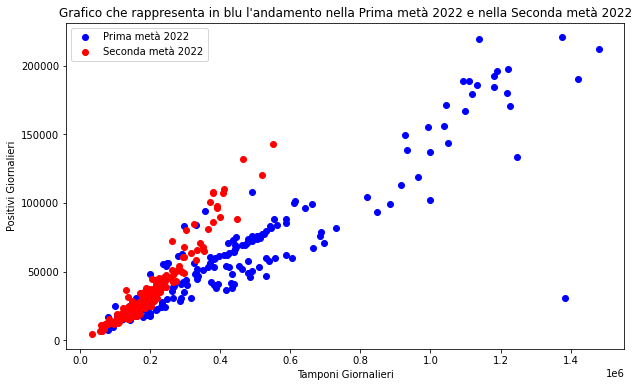

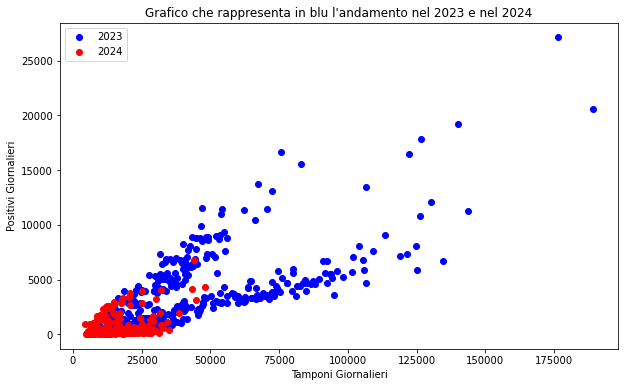

In [31]:
#2020
title = f"Grafico che rappresenta in blu l'andamento nella Prima metà 2020 e nella Seconda metà 2020"
plot_grafico(dataset1_2020, dataset2_2020, "Prima metà 2020", "Seconda metà 2020", title)


#2021
title = f"Grafico che rappresenta in blu l'andamento nella Prima metà 2021 e nella Seconda metà 2021"
plot_grafico(dataset1_2021, dataset2_2021, "Prima metà 2021", "Seconda metà 2021", title)


#2022
title = f"Grafico che rappresenta in blu l'andamento nella Prima metà 2022 e nella Seconda metà 2022"
plot_grafico(dataset1_2022, dataset2_2022, "Prima metà 2022", "Seconda metà 2022", title)


#2023-2024
title = f"Grafico che rappresenta in blu l'andamento nel 2023 e nel 2024"
plot_grafico(dataset_2023, dataset_2024, "2023", "2024", title)

Ciò che possiamo notare è un andamento del trend dei positivi e quindi una sparsità di dati che cambia di anno in anno, e in alcuni casi anche all'interno dello stesso anno ci sono differenze significative.

# SUDDIVISIONE DATASET

Questi grafici ci mostrano che anche il periodo in cui un certo dato è stato acquisito è importante ai fini di predire il numero di nuovi positivi, per questo aggiungeremo al dataset una nuova feature categorica, che per ogni record, conterrà un determinato valore in base alla data di quel record.

Creo una funzione che prende come parametri un valore x che indica in quanti sottoinsiemi vogliamo suddividere i dati appartenenti allo stesso anno, e come secondo parametro il nome della feature categorica che verrà creata.

In [32]:
#prende in input il parametro x che rappresenta il numero di sottoinsiemi per ogni anno
# quindi se ad esempio passo 2 come parametro, ogni anno verrà suddiviso in 2 sottoinsiemi,
# e ad ogni record verrà assegnata alla nuova feature un valore in base al sottoinsieme di appartenenza
def split_dataset_by_date(x, nome_colonna):
    limit = 365 / x
    categorical_value = 0
    y = 0
    for i in range(len(dataset.index)):
        #print(f"data = {dataset.index[i]}; i={i}; categorical_value={categorical_value}; y={y};")
        dataset.loc[dataset.index[i], nome_colonna] = categorical_value
        y += 1
        if(y >= limit):
            y = 0
            categorical_value += 1


Ora richiamo la funzione dividendo ogni anno in due parti:

In [33]:
nome_colonna = 'periodo_appartenenza'
split_dataset_by_date(2, nome_colonna)
dataset

,nuovi_positivi,nuovi_tamponi,nuovi_tamponi_rapidi,nuovi_tamponi_molecolari,periodo_appartenenza
data,,,,,
2020-02-24,221,4324.0,2162.0,2162.0,0.0
2020-02-25,93,4299.0,2149.5,2149.5,0.0
2020-02-26,78,964.0,482.0,482.0,0.0
2020-02-27,250,2427.0,1213.5,1213.5,0.0
2020-02-28,238,3681.0,1840.5,1840.5,0.0
...,...,...,...,...,...
2024-08-17,2271,11072.0,9953.0,1119.0,8.0
2024-08-18,1426,8604.0,7717.0,887.0,8.0
2024-08-19,956,6012.0,5436.0,576.0,8.0


# Convertire la variabile categorica

Avendo aggiunto al dataframe una variabile categorica che può assumere valori all'interno di un determinato range, trasformo questa feature categorica in n features binarie (One-Hot Encoding):

In [34]:
dummies = pd.get_dummies(dataset["periodo_appartenenza"])
dataset = pd.merge(left=dataset, right=dummies, on='data')
dataset

,nuovi_positivi,nuovi_tamponi,nuovi_tamponi_rapidi,nuovi_tamponi_molecolari,periodo_appartenenza,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
data,,,,,,,,,,,,,,
2020-02-24,221,4324.0,2162.0,2162.0,0.0,1,0,0,0,0,0,0,0,0
2020-02-25,93,4299.0,2149.5,2149.5,0.0,1,0,0,0,0,0,0,0,0
2020-02-26,78,964.0,482.0,482.0,0.0,1,0,0,0,0,0,0,0,0
2020-02-27,250,2427.0,1213.5,1213.5,0.0,1,0,0,0,0,0,0,0,0
2020-02-28,238,3681.0,1840.5,1840.5,0.0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-17,2271,11072.0,9953.0,1119.0,8.0,0,0,0,0,0,0,0,0,1
2024-08-18,1426,8604.0,7717.0,887.0,8.0,0,0,0,0,0,0,0,0,1
2024-08-19,956,6012.0,5436.0,576.0,8.0,0,0,0,0,0,0,0,0,1


Dato che ho aggiunto nuove features al dataset ricalcolo i dataset relativi ai singoli anni, dopo aver eliminato la variabile categorica:

In [35]:
dataset = dataset.drop(['periodo_appartenenza'], axis=1)

In [105]:
#### RICREO I DATASET

dataset1_2020 = dataset[indici < meta_2020]
dataset2_2020 = dataset[(indici > meta_2020 ) & (indici < inizio_2021)]

#2021
dataset1_2021 = dataset[(indici > inizio_2021) & (indici < meta_2021)]
dataset2_2021 = dataset[(indici > meta_2021) & (indici < inizio_2022)]

#2022
dataset1_2022 = dataset[(indici > inizio_2022) & (indici < meta_2022)]
dataset2_2022 = dataset[(indici > meta_2022) & (indici < inizio_2023)]

#2023
dataset_2023 = dataset[(indici > inizio_2023) & (indici < inizio_2024)]
dataset1_2023 = dataset[(indici > inizio_2023) & (indici < meta_2023)]
dataset2_2023 = dataset[(indici > meta_2023) & (indici < inizio_2024)]

#2024
dataset_2024 = dataset[(indici > inizio_2024)]

# CREAZIONE DEI MODELLI

Per prima cosa importiamo packages necessari

In [106]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold


Poi creiamo delle funzioni che ci torneranno utili dopo:

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def print_eval(X, y, model):
    preds = model.predict(X)
    #mse = mean_squared_error(y, preds)
    re = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    #print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

In [39]:
def plot_model_on_data(x, y, model=None, title=None, ax=None):
    if ax is None:
        plt.figure(figsize=(9, 6))
        ax = plt.gca()
    ax.scatter(x, y)
    if model is not None:
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        plot_x = np.linspace(xlim[0], xlim[1], 100)
        plot_y = model(plot_x)
        ax.plot(plot_x, plot_y, lw=3, c="red")
        ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.grid()
    ax.set_title(title)
    ax.set_xlabel("Tamponi Giornalieri")
    ax.set_ylabel("Positivi Giornalieri")

In [40]:
def plot_singolo_grafico(dataset, label, title):
    # Creare il grafico
    plt.figure(figsize=(10, 6))
    plt.scatter(dataset['nuovi_tamponi'], dataset['nuovi_positivi'], label=label, color="blue")

    # Aggiungere etichette e titolo
    plt.xlabel('Tamponi Giornalieri')
    plt.ylabel('Positivi Giornalieri')
    plt.title(title)
    plt.legend()

In [41]:
def print_data(X_train, X_test, y_train, y_test, model):
    print("TRAIN -----------------------")
    print_eval(X_train, y_train, model)
    print("TEST ------------------------")
    print_eval(X_test, y_test, model)

Come abbiamo visto ci troviamo in una situazione in cui dati sono molto sparsi, ora creeremo dei modelli, di diverse tipogie, addestrati e testati sia sull'intero dataset, sia sui dataset contenenti i dati dei singoli anni, per confrontarli tra di loro.

Per prima cosa creiamo i dataset relativi ai singoli anni, unendo i dataset creati prima (i dataset per il 2023 e 2024 li ho creati prima):

In [42]:
dataset_2020 = pd.concat([dataset1_2020, dataset2_2020])

dataset_2021 = pd.concat([dataset1_2021, dataset2_2021])

dataset_2022 = pd.concat([dataset1_2022, dataset2_2022])

Ora procediamo alla creazione dei modelli.

# PREVISIONI INTERO DATASET

Iniziamo creando un semplice modello di regressione lineare:  

In [43]:
X = dataset.drop('nuovi_positivi', axis=1)
y = dataset['nuovi_positivi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
simple_model =  LinearRegression()
simple_model.fit(X_train, y_train)
print_data(X_train, X_test, y_train, y_test, simple_model)

TRAIN -----------------------
       Relative error: 233.27990%
R-squared coefficient: 0.78112
TEST ------------------------
       Relative error: 257.14044%
R-squared coefficient: 0.80893


Ora creo una pipeline dove uso il modello Ridge, con normalizzazione minimo-massimo e regressione polinomiale facendo uso amche della k-Fold Cross Validation:

In [45]:
kfold_5 = KFold(5, shuffle=True, random_state=42)

In [46]:
modelRidge = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", MinMaxScaler()),
    ("regr",  Ridge())
])

In [47]:
grid = {
    # grado polinomio (parametro "degree" del filtro "poly")
    "poly__degree": [2, 3],
    # peso regolarizzazione (parametro "alpha" del modello "regr")
    "regr__alpha":  [0.1, 1, 10],
}

gs = GridSearchCV(modelRidge, grid, cv=kfold_5)
gs.fit(X_train, y_train);
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_regr__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.006404,0.000489,0.001994,0.000002,2,10,"{'poly__degree': 2, 'regr__alpha': 10}",0.796931,0.723210,0.777708,0.774701,0.854802,0.785470,0.042405,1
1,0.007399,0.000802,0.002800,0.000401,2,1,"{'poly__degree': 2, 'regr__alpha': 1}",0.834737,0.391167,0.780282,0.806977,0.860840,0.734801,0.173917,2
5,0.022469,0.000453,0.002598,0.000490,3,10,"{'poly__degree': 3, 'regr__alpha': 10}",0.825673,0.324160,0.778485,0.811030,0.871628,0.722195,0.201261,3
3,0.023802,0.001325,0.003402,0.000495,3,0.1,"{'poly__degree': 3, 'regr__alpha': 0.1}",0.906954,0.073496,0.801081,0.868344,0.910772,0.712130,0.321740,4
0,0.010997,0.003637,0.003203,0.000402,2,0.1,"{'poly__degree': 2, 'regr__alpha': 0.1}",0.869101,-0.151150,0.767438,0.835254,0.864726,0.637074,0.395785,5
4,0.022802,0.001165,0.002400,0.000488,3,1,"{'poly__degree': 3, 'regr__alpha': 1}",0.870928,-0.364176,0.789071,0.843887,0.890833,0.606108,0.486346,6


Ora vediamo come si comporta il modello:

In [48]:
print_data(X_train, X_test, y_train, y_test, gs)

TRAIN -----------------------
       Relative error: 155.30528%
R-squared coefficient: 0.81358
TEST ------------------------
       Relative error: 145.19578%
R-squared coefficient: 0.83706


Possiamo notare che rispetto al semplice modello lineare precedente c'è stato un miglioramento, un'altra prova che voglio fare è vedere se le features che ho aggiunto servono effettivamente ad ottenere un modello migliore, per questo uso il modello precedente ma lo addestrerò usando la sola feature `nuovi_tamponi` e non usando le altre features aggiunte da me.

Creo i nuovi training e test sets:

In [49]:
X_prova = dataset[['nuovi_tamponi']]
y_prova = dataset['nuovi_positivi']

X_prova_train, X_prova_test, y_prova_train, y_prova_test = train_test_split(X_prova, y_prova, test_size=0.2, random_state=42)

Cerco i parametri migliori:

In [50]:
gs.fit(X_prova_train, y_prova_train);
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_regr__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.004001,0.000003,0.001999,0.000634,3,1,"{'poly__degree': 3, 'regr__alpha': 1}",0.663533,0.601656,0.599942,0.583970,0.764841,0.642789,0.066805,1
1,0.003799,0.000399,0.001199,0.000399,2,1,"{'poly__degree': 2, 'regr__alpha': 1}",0.656693,0.623925,0.598647,0.573362,0.760826,0.642691,0.065193,2
3,0.004006,0.000634,0.001994,0.000010,3,0.1,"{'poly__degree': 3, 'regr__alpha': 0.1}",0.663540,0.589935,0.603128,0.574151,0.768712,0.639893,0.071166,3
0,0.004412,0.000812,0.001799,0.000405,2,0.1,"{'poly__degree': 2, 'regr__alpha': 0.1}",0.659222,0.611988,0.596535,0.566322,0.764640,0.639741,0.069291,4
5,0.003601,0.000490,0.001800,0.000400,3,10,"{'poly__degree': 3, 'regr__alpha': 10}",0.623681,0.586407,0.571222,0.593985,0.721970,0.619453,0.054027,5
2,0.003399,0.000489,0.001600,0.000493,2,10,"{'poly__degree': 2, 'regr__alpha': 10}",0.607998,0.595424,0.570679,0.576670,0.701399,0.610434,0.047384,6


In [51]:
print_data(X_prova_train, X_prova_test, y_prova_train, y_prova_test, gs)

TRAIN -----------------------
       Relative error: 423.29512%
R-squared coefficient: 0.66342
TEST ------------------------
       Relative error: 412.13763%
R-squared coefficient: 0.66542


Possiamo vedere che senza le features aggiuntive avrei dei valori di valutazione del modello nettamente peggiori.

Un'ultima prova che farò è quella di usare sempre lo stesso modello, con tutte le features, ma a differenza di prima suddividerò i dati in training set e test set usando la data e non la funzione train_test_split(), effettuerò una suddivisione 50-50 perché altrimenti nel test set avrei soprattutto dati di fine pandemia:

In [53]:
is_train =  pd.to_datetime(dataset.index).year < 2022

X_prova_train = X.loc[is_train]
y_prova_train = y[is_train]
X_prova_test = X.loc[~is_train]
y_prova_test = y[~is_train]

I dati del 2020 e 2021 fanno parte del training set e i restanti del test set, ora cerco i parametri migliori:

In [54]:
gs.fit(X_prova_train, y_prova_train)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_regr__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.016401,0.002055,0.001998,8.449576e-07,3,0.1,"{'poly__degree': 3, 'regr__alpha': 0.1}",0.791424,0.816670,0.898156,0.861713,0.843184,0.842229,0.036723,1
4,0.014204,0.000399,0.002397,4.870835e-04,3,1,"{'poly__degree': 3, 'regr__alpha': 1}",0.767894,0.785635,0.892694,0.842869,0.826102,0.823039,0.044033,2
0,0.006802,0.000974,0.002597,4.909090e-04,2,0.1,"{'poly__degree': 2, 'regr__alpha': 0.1}",0.744847,0.707537,0.862379,0.815541,0.818264,0.789713,0.055729,3
1,0.005204,0.000399,0.001995,4.862804e-07,2,1,"{'poly__degree': 2, 'regr__alpha': 1}",0.686419,0.697758,0.812507,0.763098,0.758396,0.743636,0.046300,4
5,0.014204,0.000399,0.002395,4.900814e-04,3,10,"{'poly__degree': 3, 'regr__alpha': 10}",0.690136,0.735956,0.807484,0.749246,0.729987,0.742562,0.037973,5
2,0.005005,0.000002,0.001794,3.996180e-04,2,10,"{'poly__degree': 2, 'regr__alpha': 10}",0.636179,0.717368,0.672553,0.639807,0.654130,0.664007,0.029591,6


Visualizzo i risultati:

In [55]:
print_data(X_prova_train, X_prova_test, y_prova_train, y_prova_test, gs)

TRAIN -----------------------
       Relative error: 138.43005%
R-squared coefficient: 0.86098
TEST ------------------------
       Relative error: 452.94819%
R-squared coefficient: 0.20103


Si può vedere che effettuando questa tipologia di split ottengo valori molto diversi tra training set e test set, questo perché come abbiamo visto anche prima, ci sono notevoli differenze nei dati a seconda dell'anno.

Proprio a causa di queste differenze da un anno all'altro, ora creerò nuovi modelli che addestrerò su dataset più piccoli che si riferiscono ai singoli anni, l'obiettivo è quello di concentrarsi su intervalli di tempo più piccoli per vedere se si possono ottenere dei modelli migliori.

# 2020

Per prima cosa vediamo il grafico relativo al 2020:

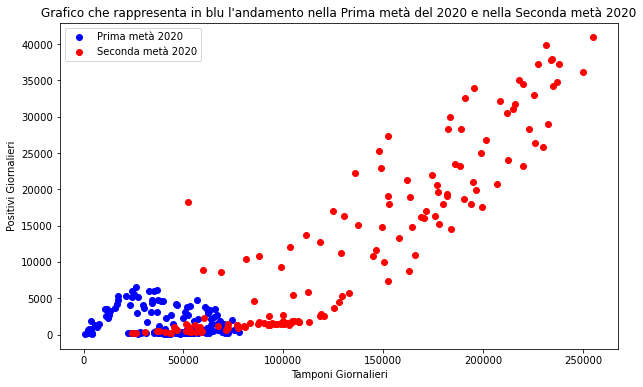

In [56]:
#2020
title = f"Grafico che rappresenta in blu l'andamento nella Prima metà del 2020 e nella Seconda metà 2020"
plot_grafico(dataset1_2020, dataset2_2020, "Prima metà 2020", "Seconda metà 2020", title)

Notiamo un andamento abbastanza diverso tra la prima metà e la seconda metà del 2020, usiamo il dataset che si riferisce ai dati dell'intero 2020, questa volta useremo una regressione Lasso, con standardizzazione eseguita con filtro `StandardScaler`:

In [57]:
X_2020 = dataset_2020.drop('nuovi_positivi', axis=1)
y_2020 = dataset_2020['nuovi_positivi']

X_train_2020, X_test_2020, y_train_2020, y_test_2020 = train_test_split(X_2020, y_2020, test_size=0.2, random_state=42)

In [58]:
modelLasso = Pipeline([
     ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=1))
])
modelLasso.fit(X_train_2020, y_train_2020)
print_data(X_train_2020, X_test_2020, y_train_2020, y_test_2020, modelLasso)

TRAIN -----------------------
       Relative error: 203.59872%
R-squared coefficient: 0.89259
TEST ------------------------
       Relative error: 190.43475%
R-squared coefficient: 0.81163


Notiamo che l'errore relativo è alto, mentre Il _coefficiente di determinazione_ $R^2$ ha un buon valore, proviamo ora a creare dei modelli separati, uno per la prima metà del 2020, e un altro per la seconda metà:

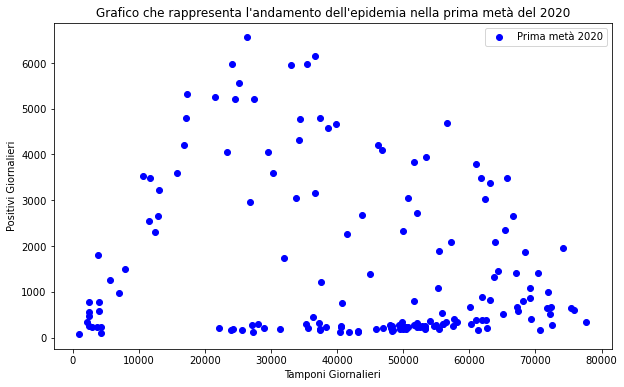

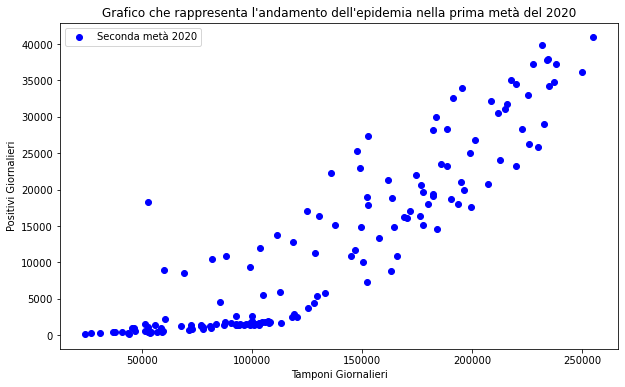

In [60]:
title = f"Grafico che rappresenta l'andamento dell'epidemia nella prima metà del 2020"
plot_singolo_grafico(dataset1_2020, "Prima metà 2020", title)

title = f"Grafico che rappresenta l'andamento dell'epidemia nella prima metà del 2020"
plot_singolo_grafico(dataset2_2020, "Seconda metà 2020", title)

Si può capire già graficamente che il modello per la seconda metà del 2020 sarà più preciso perché sono dei dati più interpretabili, invece nella prima metà del 2020 sono molto sparsi, utilizziamo lo stesso modello usato per il dataset del 2020, ma applicato ai due dataset creati in precedenza:

#### Prima metà 2020

In [61]:
X1_2020 = dataset1_2020.drop('nuovi_positivi', axis=1)
y1_2020 = dataset1_2020['nuovi_positivi']

X1_train_2020, X1_test_2020, y1_train_2020, y1_test_2020 = train_test_split(X1_2020, y1_2020, test_size=0.2, random_state=42)

In [62]:
modelLasso = Pipeline([
     ("poly",  PolynomialFeatures(degree=4, include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=1))
])
modelLasso.fit(X1_train_2020, y1_train_2020)
print_data(X1_train_2020, X1_test_2020, y1_train_2020, y1_test_2020, modelLasso)

TRAIN -----------------------
       Relative error: 283.09103%
R-squared coefficient: 0.20257
TEST ------------------------
       Relative error: 379.71170%
R-squared coefficient: 0.18615


Vediamo che come ci aspettavamo il modello non performa per niente bene, e a differenza del modello precedente ho usato anche un grado maggiore per la polynomial feature, altrimenti performava anche peggio, invece ora applichiamo lo stesso modello al dataset della seconda metà del 2020, e mi aspetto un incremento notevole delle performance del modello:

#### Seconda metà 2020

In [63]:
X2_2020 = dataset2_2020.drop('nuovi_positivi', axis=1)
y2_2020 = dataset2_2020['nuovi_positivi']

X2_train_2020, X2_test_2020, y2_train_2020, y2_test_2020 = train_test_split(X2_2020, y2_2020, test_size=0.2, random_state=42)

In [64]:
modelLasso = Pipeline([
     ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=1))
])
modelLasso.fit(X2_train_2020, y2_train_2020)
print_data(X2_train_2020, X2_test_2020, y2_train_2020, y2_test_2020, modelLasso)

TRAIN -----------------------
       Relative error: 70.68422%
R-squared coefficient: 0.86122
TEST ------------------------
       Relative error: 64.52298%
R-squared coefficient: 0.8513


Come mi aspettavo gli indici di valutazione di questo modello sono nettamente migliori rispetto a quello della prima metà del 2020, da notare che l'epidemia è scoppiata nei primi mesi del 2020 e quindi questo potrebbe essere uno dei motivi della sparsità dei dati nella prima metà del 2020.

# 2021

Come fatto prima visualizziamo prima i grafici dell''andamento dell'epidemia:

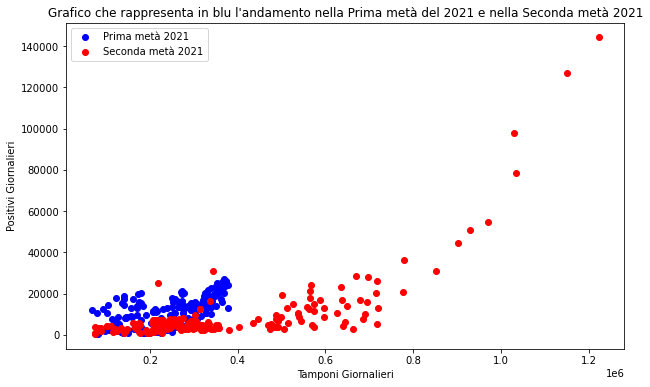

In [65]:
title = f"Grafico che rappresenta in blu l'andamento nella Prima metà del 2021 e nella Seconda metà 2021"
plot_grafico(dataset1_2021, dataset2_2021, "Prima metà 2021", "Seconda metà 2021", title)

Notiamo che nella seconda metà del 2021 il numero di positivi inizia ad aumentare, questo perché nel 2022 abbiamo avuto poi il picco dei contagi, e quindi, come giustamente vediamo anche dal grafico, i positivi iniziano ad aumentare già a partire dalla seconda metà 2021.

Questa volta useremo una regressione elastic net:


In [66]:
X_2021 = dataset_2021.drop('nuovi_positivi', axis=1)
y_2021 = dataset_2021['nuovi_positivi']

X_train_2021, X_test_2021, y_train_2021, y_test_2021 = train_test_split(X_2021, y_2021, test_size=0.2, random_state=42)

In [67]:
kfold_5 = KFold(5, shuffle=True, random_state=42)

In [68]:
modelElastic = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("regr", ElasticNet())
])

In [69]:
grid = {
    "poly__degree": [2, 3, 4],
    "regr__alpha":    [0.1, 1, 10],
    "regr__l1_ratio": [0.1, 0.2, 0.5]
}
gs = GridSearchCV(modelElastic, grid, cv=kfold_5)
gs.fit(X_train_2021, y_train_2021)
print_data(X_train_2021, X_test_2021, y_train_2021, y_test_2021, gs)

TRAIN -----------------------
       Relative error: 55.22494%
R-squared coefficient: 0.93341
TEST ------------------------
       Relative error: 52.64270%
R-squared coefficient: 0.80188


Abbiamo ottenuto un modello che si comporta molto meglio rispetto al modello addestrato e testato sull'intero 2020.

Ora guardiamo in dettaglio i grafici relativi alla prima e alla seconda metà del 2021:

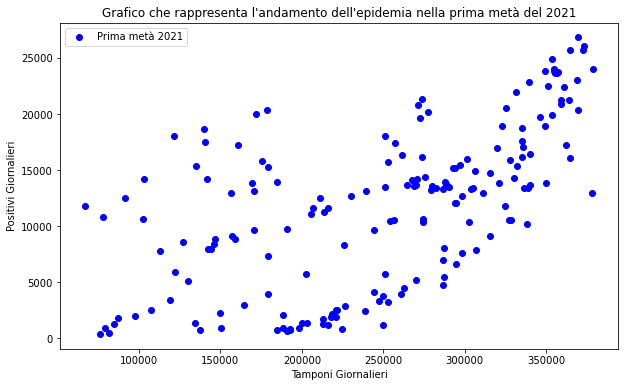

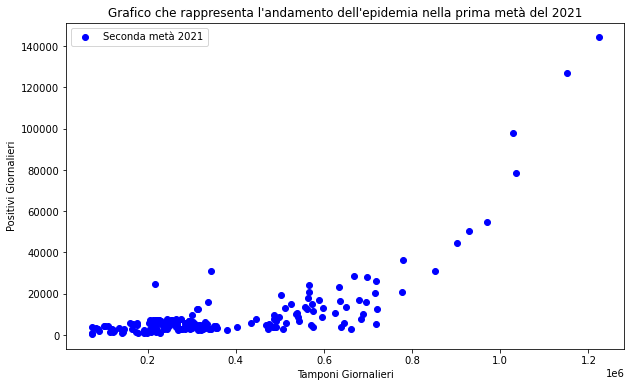

In [70]:
title = f"Grafico che rappresenta l'andamento dell'epidemia nella prima metà del 2021"
plot_singolo_grafico(dataset1_2021, "Prima metà 2021", title)

title = f"Grafico che rappresenta l'andamento dell'epidemia nella prima metà del 2021"
plot_singolo_grafico(dataset2_2021, "Seconda metà 2021", title)

Come successo per il 2020 nel primo grafico notiamo una grande sparsità dei dati (anche se meno rispetto al 2020), mentre nel secondo grafico l'andamento è più prevedibile e quindi anche in questo caso mi aspetto che il modello addestrato sul dataset relativo alla seconda metà del 2021 sia migliore di quello della prima metà.

Ora usiamo lo stesso modello precedente ma lo addestriamo e testiamo sulla prima e sulla seconda metà del 2021:

#### Prima metà 2021

In [71]:
X1_2021 = dataset1_2021.drop('nuovi_positivi', axis=1)
y1_2021 = dataset1_2021['nuovi_positivi']

X1_train_2021, X1_test_2021, y1_train_2021, y1_test_2021 = train_test_split(X1_2021, y1_2021, test_size=0.2, random_state=42)

In [72]:
gs = GridSearchCV(modelElastic, grid, cv=kfold_5)
gs.fit(X1_train_2021, y1_train_2021)
print_data(X1_train_2021, X1_test_2021, y1_train_2021, y1_test_2021, gs)

TRAIN -----------------------
       Relative error: 50.57001%
R-squared coefficient: 0.7707
TEST ------------------------
       Relative error: 48.04986%
R-squared coefficient: 0.73471


#### Seconda metà 2021

In [73]:
X2_2021 = dataset2_2021.drop('nuovi_positivi', axis=1)
y2_2021 = dataset2_2021['nuovi_positivi']

X2_train_2021, X2_test_2021, y2_train_2021, y2_test_2021 = train_test_split(X2_2021, y2_2021, test_size=0.2, random_state=42)

In [74]:
gs.fit(X2_train_2021, y2_train_2021)
print_data(X2_train_2021, X2_test_2021, y2_train_2021, y2_test_2021, gs)

TRAIN -----------------------
       Relative error: 57.34236%
R-squared coefficient: 0.95251
TEST ------------------------
       Relative error: 38.09596%
R-squared coefficient: 0.88153


Abbiamo ottenuto dei valori che sono in linea con il modello addestrato e testato sull'intero 2021

# 2022

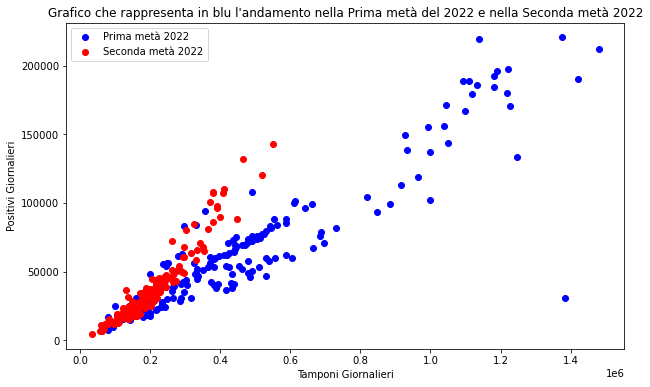

In [75]:
title = f"Grafico che rappresenta in blu l'andamento nella Prima metà del 2022 e nella Seconda metà 2022"
plot_grafico(dataset1_2022, dataset2_2022, "Prima metà 2022", "Seconda metà 2022", title)

Possiamo vedere che nel 2022, rispetto al 2020 e 2021, l'andamento tra la prima e la seconda metà è più simile

In [76]:
#creo X e y
X_2022 = dataset_2022.drop('nuovi_positivi', axis=1)
y_2022 = dataset_2022['nuovi_positivi']

X_train_2022, X_test_2022, y_train_2022, y_test_2022 = train_test_split(X_2022, y_2022, test_size=0.2, random_state=42)

In [77]:
modelKernel = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly"))
])

In [78]:
gridKernel = {
    "regr__degree": [2, 3, 4],
    "regr__alpha":  np.linspace(0.1, 10, 20),
}

gs = GridSearchCV(modelKernel, gridKernel, cv=kfold_5)
gs.fit(X_train_2022, y_train_2022);
print_data(X_train_2022, X_test_2022, y_train_2022, y_test_2022, gs)

TRAIN -----------------------
       Relative error: 13.18028%
R-squared coefficient: 0.96584
TEST ------------------------
       Relative error: 11.96942%
R-squared coefficient: 0.9491


Dagli indici di valutazione del modello possiamo vedere ciò che avevamo già osservato nel grafico, ovvero che l'andamento tra la prima metà e la seconda metà è simile, e quindi questo modello, che è stato addestrato e testato sull'intero 2022, si comporta in maniera migliore rispetto agli altri modelli addestrati e testati sull'intero 2020 e 2021.

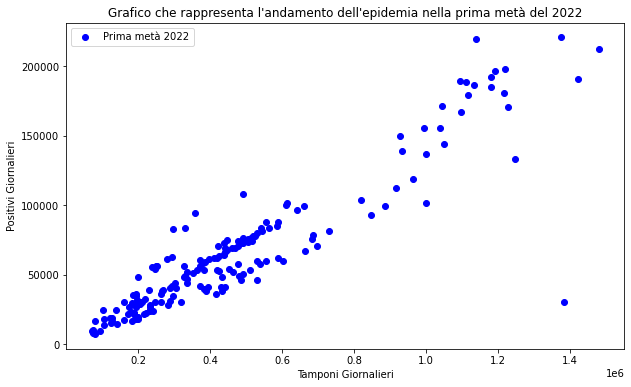

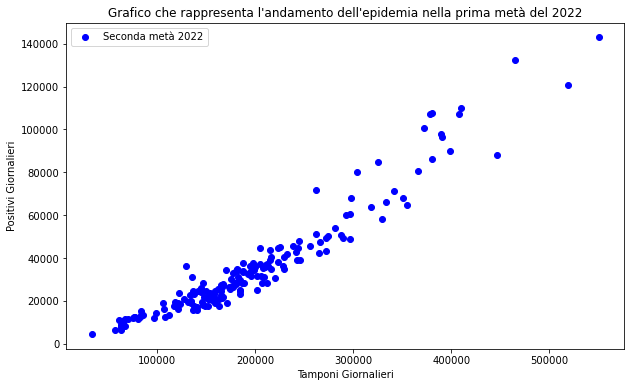

In [79]:
title = f"Grafico che rappresenta l'andamento dell'epidemia nella prima metà del 2022"
plot_singolo_grafico(dataset1_2022, "Prima metà 2022", title)

title = f"Grafico che rappresenta l'andamento dell'epidemia nella prima metà del 2022"
plot_singolo_grafico(dataset2_2022, "Seconda metà 2022", title)

Come fatto prima, anche se qui c'è ne meno bisogno, perché il modello trovato già si comporta bene, applichiamo lo stesso modello ai dati della prima e della seconda metà del 2022:

#### Prima metà 2022

In [80]:
X1_2022 = dataset1_2022.drop('nuovi_positivi', axis=1)
y1_2022 = dataset1_2022['nuovi_positivi']

X1_train_2022, X1_test_2022, y1_train_2022, y1_test_2022 = train_test_split(X1_2022, y1_2022, test_size=0.2, random_state=42)

In [81]:
gs.fit(X1_train_2022, y1_train_2022);
print_data(X1_train_2022, X1_test_2022, y1_train_2022, y1_test_2022, gs)

TRAIN -----------------------
       Relative error: 18.83272%
R-squared coefficient: 0.93851
TEST ------------------------
       Relative error: 22.58130%
R-squared coefficient: 0.95759


#### Seconda metà 2022

In [82]:
X2_2022 = dataset2_2022.drop('nuovi_positivi', axis=1)
y2_2022 = dataset2_2022['nuovi_positivi']

X2_train_2022, X2_test_2022, y2_train_2022, y2_test_2022 = train_test_split(X2_2022, y2_2022, test_size=0.2, random_state=42)

In [83]:
gs.fit(X2_train_2022, y2_train_2022);
print_data(X2_train_2022, X2_test_2022, y2_train_2022, y2_test_2022, gs)

TRAIN -----------------------
       Relative error: 10.35719%
R-squared coefficient: 0.9677
TEST ------------------------
       Relative error: 12.01138%
R-squared coefficient: 0.88071


Entrambi i modelli hanno buoni indici di valutazione, e tra quelli analizzati fino ad ora il 2022 è quello più "prevedibile", ovvero quello dove il modello trovato ha la percentuale di errore più bassa.

# 2023

Ora valutiamo i dati del 2023:

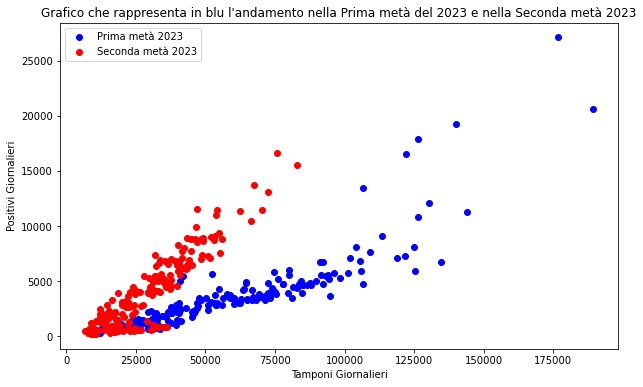

In [84]:
title = f"Grafico che rappresenta in blu l'andamento nella Prima metà del 2023 e nella Seconda metà 2023"
plot_grafico(dataset1_2023, dataset2_2023, "Prima metà 2023", "Seconda metà 2023", title)

Notiamo che l'andamento è diverso all'interno del 2023, con i punti del grafico che quasi formano due linee ben distinguibili, proviamo ora ad usare il modello usato per il 2022, cercando ovviamente prima i migliori parametri da usare:

In [89]:
#creo X e y
X_2023 = dataset_2023.drop('nuovi_positivi', axis=1)
y_2023 = dataset_2023['nuovi_positivi']

X_train_2023, X_test_2023, y_train_2023, y_test_2023 = train_test_split(X_2023, y_2023, test_size=0.2, random_state=42)

In [87]:
modelKernel = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly"))
])

In [91]:
gs = GridSearchCV(modelKernel, gridKernel, cv=kfold_5)
gs.fit(X_train_2023, y_train_2023);
print_data(X_train_2023, X_test_2023, y_train_2023, y_test_2023, gs)

TRAIN -----------------------
       Relative error: 27.63917%
R-squared coefficient: 0.91956
TEST ------------------------
       Relative error: 29.94860%
R-squared coefficient: 0.86206


Possiamo vedere che il modello non performa benissimo, proviamo invece a scomporre il dataset del 2023 in 2 parti e vediamo se riusciamo a trovare dei modelli migliori:

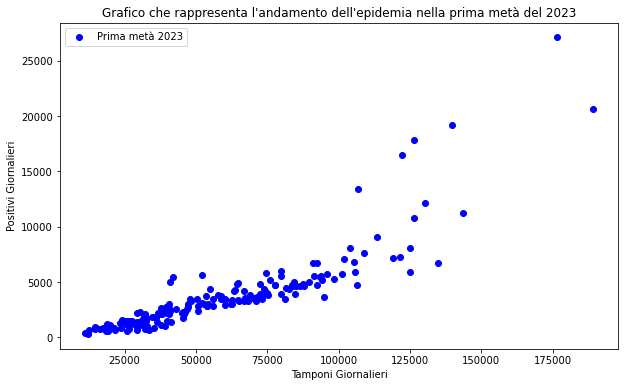

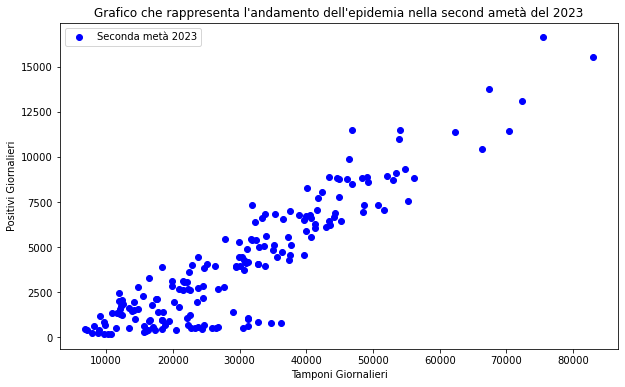

In [92]:
title = f"Grafico che rappresenta l'andamento dell'epidemia nella prima metà del 2023"
plot_singolo_grafico(dataset1_2023, "Prima metà 2023", title)

title = f"Grafico che rappresenta l'andamento dell'epidemia nella second ametà del 2023"
plot_singolo_grafico(dataset2_2023, "Seconda metà 2023", title)

Tra le prima e la seconda parte del 2023 l'andamente è diverso ed ora cercheremo i parametri del modello migliori addestrando e testando su questi 2 dataset:

#### Prima metà 2023

In [93]:
X1_2023 = dataset1_2023.drop('nuovi_positivi', axis=1)
y1_2023 = dataset1_2023['nuovi_positivi']

X1_train_2023, X1_test_2023, y1_train_2023, y1_test_2023 = train_test_split(X1_2023, y1_2023, test_size=0.2, random_state=42)

Cerchiamo i parametri:

In [94]:
gridKernel = {
    "regr__degree": [1, 2, 3],
    "regr__alpha":  np.linspace(0.1, 10, 20),
}

gs = GridSearchCV(modelKernel, gridKernel, cv=kfold_5)
gs.fit(X1_train_2023, y1_train_2023);
print_data(X1_train_2023, X1_test_2023, y1_train_2023, y1_test_2023, gs)

TRAIN -----------------------
       Relative error: 27.71039%
R-squared coefficient: 0.87719
TEST ------------------------
       Relative error: 19.81648%
R-squared coefficient: 0.87449


#### Seconda metà 2023

In [95]:
X2_2023 = dataset2_2023.drop('nuovi_positivi', axis=1)
y2_2023 = dataset2_2023['nuovi_positivi']

X2_train_2023, X2_test_2023, y2_train_2023, y2_test_2023 = train_test_split(X2_2023, y2_2023, test_size=0.2, random_state=42)

In [96]:
gs = GridSearchCV(modelKernel, gridKernel, cv=kfold_5)
gs.fit(X2_train_2023, y2_train_2023);
print_data(X2_train_2023, X2_test_2023, y2_train_2023, y2_test_2023, gs)

TRAIN -----------------------
       Relative error: 26.05904%
R-squared coefficient: 0.95518
TEST ------------------------
       Relative error: 25.40513%
R-squared coefficient: 0.92687


Otteniamo delle prestazioni simili da entrambi i modelli, che si comportano leggermente meglio rispetto al modello addestrato e testato sull'intero dataset del 2023

# PREVISIONI 2024

Infine occupiamoci dei dati relativi al dataset del 2024, che contiene i dati da inizio 2024 fino da oggi, creiamo i training e test sets e visualizziamo il grafico:

In [97]:
X_2024 = dataset_2024.drop('nuovi_positivi', axis=1)
y_2024 = dataset_2024['nuovi_positivi']

X_train_2024, X_test_2024, y_train_2024, y_test_2024 = train_test_split(X_2024, y_2024, test_size=0.2, random_state=42)

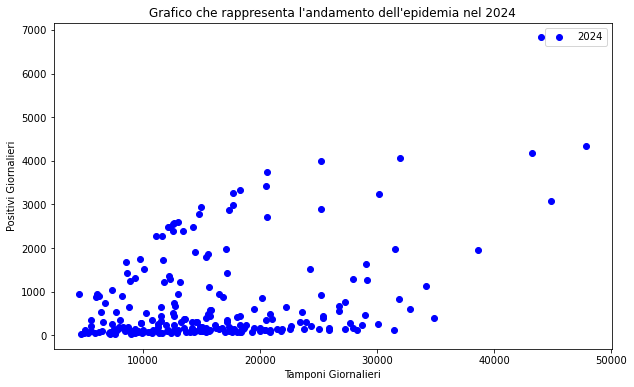

In [98]:
title = f"Grafico che rappresenta l'andamento dell'epidemia nel 2024"
plot_singolo_grafico(dataset_2024, "2024", title)

Notiamo una grande sparsità di dati, per questo non mi aspetto un errore molto alto:

In [99]:
gs = GridSearchCV(modelKernel, gridKernel, cv=kfold_5)
gs.fit(X_train_2024, y_train_2024);
print_data(X_train_2024, X_test_2024, y_train_2024, y_test_2024, gs)

TRAIN -----------------------
       Relative error: 257.73696%
R-squared coefficient: 0.44609
TEST ------------------------
       Relative error: 223.71836%
R-squared coefficient: 0.38155


Anche se i dati relativi al 2024 sono minori rispetto agli altri anni, perché al momento sono presenti i dati da gennaio ad agosto, proviamo comunque a suddividere i dati in due parti e vediamo se otteniamo valutazioni migliori:

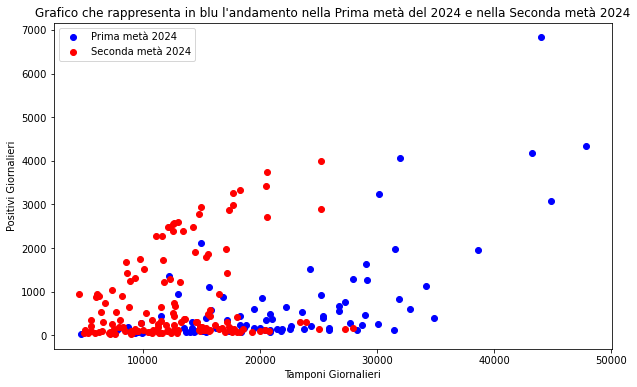

In [100]:
#2024
date_split_2024 = pd.to_datetime('2024-04-01')

#2024
dataset1_2024 = dataset[(indici >= inizio_2024) & (indici <= date_split_2024)]
dataset2_2024 = dataset[(indici > date_split_2024)]

title = f"Grafico che rappresenta in blu l'andamento nella Prima metà del 2024 e nella Seconda metà 2024"
plot_grafico(dataset1_2024, dataset2_2024, "Prima metà 2024", "Seconda metà 2024", title)

Nonostante la suddivisione si vede dal grafico che continua ad esserci molta sparsità dei dati in entrambi i dataset, quindi non mi aspetto di ottenere dei risultati simili ai modelli testati sugli anni precedenti:

#### Prima parte 2024

In [101]:
X1_2024 = dataset1_2024.drop('nuovi_positivi', axis=1)
y1_2024 = dataset1_2024['nuovi_positivi']

X1_train_2024, X1_test_2024, y1_train_2024, y1_test_2024 = train_test_split(X1_2024, y1_2024, test_size=0.2, random_state=42)

In [102]:
gs = GridSearchCV(modelKernel, gridKernel, cv=kfold_5)
gs.fit(X1_train_2024, y1_train_2024);
print_data(X1_train_2024, X1_test_2024, y1_train_2024, y1_test_2024, gs)

TRAIN -----------------------
       Relative error: 71.57399%
R-squared coefficient: 0.77236
TEST ------------------------
       Relative error: 98.36920%
R-squared coefficient: 0.38716


Otteniamo unerore relativo migliore rispetto al modello dell'intero 2024, ma un _coefficiente di determinazione_ $R^2$ basso soprattutto per il test set.

#### Seconda parte 2024

In [103]:
X2_2024 = dataset2_2024.drop('nuovi_positivi', axis=1)
y2_2024 = dataset2_2024['nuovi_positivi']

X2_train_2024, X2_test_2024, y2_train_2024, y2_test_2024 = train_test_split(X2_2024, y2_2024, test_size=0.2, random_state=42)

In [104]:
gs = GridSearchCV(modelKernel, gridKernel, cv=kfold_5)
gs.fit(X2_train_2024, y2_train_2024);
print_data(X2_train_2024, X2_test_2024, y2_train_2024, y2_test_2024, gs)

TRAIN -----------------------
       Relative error: 289.07276%
R-squared coefficient: 0.34992
TEST ------------------------
       Relative error: 280.65615%
R-squared coefficient: 0.035902


Qui invece abbiamo sia un errore relativo troppo alto che un _coefficiente di determinazione_ $R^2$ troppo basso  

# Conclusioni

L'obiettivo di questo progetto era quello di cercare di prevedere il numero di nuovi positivi di covid-19, trattandosi di un fenomeno molto imprevedibile, con periodi dove il numero di nuovi positivi era molto alto e periodi dove era molto basso, ho capito subito, guardando i grafici, che per avere modelli più precisi dovevo suddividere il dataset iniziale (2020-2024) in più datasets, uno per ogni anno, che a sua volta ho suddiviso in altri datasets, perché dai grafici si vedeva che anche all'interno di uno stesso anno i dati erano sparsi.   

Infatti tranne per il 2024 dove i dati erano veramente molto sparsi, i modelli addestrati e testati sulla prima e seconda parte di un determinato anno hanno ottenuto errori più bassi del modello addestrato sull'intero anno.

Una conclusione che posso trarre da ciò, è che per fenomeni come il covid-19 dove non ho una continuità di anno in anno, ma ho molta imprevidibilità, è difficile fare previsioni a lungo termine, infatti proprio per questo motivo i modelli con le valutazioni migliori sono quelli addestrati e testati su intervalli di tempo più piccoli (pochi mesi).  